In [97]:
from PIL import Image
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [98]:
#identify images path for future use
PATH = "/Users/My_Drive/Desktop/amliNet/Data"
#load the csv file to load targets
df = pd.read_csv(PATH + "/train.csv")

In [99]:
# csv file has different image path, we change to math to our directory

def edit_urls(url):
    pieces = url.split('/')
    newurl=''
    for i, piece in enumerate(pieces):
        if i>0:
            newurl += '/' + piece
        elif i==0:
            newurl += PATH
    return newurl

/Users/My_Drive/Desktop/amliNet/Data/train/patient00001/study1/view1_frontal.jpg


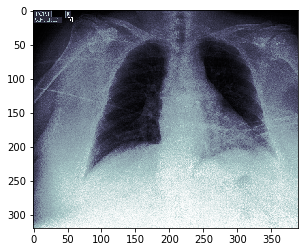

In [100]:
#testing
tester_url = edit_urls(df.iloc[0]['Path'])
print( tester_url )
xray = Image.open(tester_url)
plt.imshow(xray, cmap="bone")
plt.show()

In [101]:
#Change the path for all images
df["Path"] = df["Path"].apply(edit_urls)

In [102]:
#identify what features will be used for model training
outcomes = ['No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices'
]
#fill missing values with zeros, and assign all unsertain values (-1) to positive (1)
df[outcomes] = df[outcomes].fillna(0)
df[outcomes] = df[outcomes].replace(-1, 1)

In [103]:
#Train/test split
image_train, image_test, label_train, label_test = train_test_split(
   df['Path'], df[outcomes], test_size=0.2, random_state=42)

#Create train and test dataframes
train_df = pd.concat([image_train, label_train], axis=1)
test_df = pd.concat([image_test, label_test], axis=1)

#For the classifier to work, for some reason it has to be in string format
test_df['No Finding'] = test_df['No Finding'].apply(str)
train_df['No Finding'] = train_df['No Finding'].apply(str)

In [104]:
from keras.preprocessing.image import ImageDataGenerator


datagen=ImageDataGenerator(rescale=1./255,
                           shear_range=0.2,
                           zoom_range=0.2,
                           horizontal_flip=True) #scale the color information to 0 to 1 instead of 0 to 255

train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='Path',
    y_col='No Finding',
    color_mode='grayscale',
    target_size=(256, 256),
    class_mode='binary')

test_generator = datagen.flow_from_dataframe(
    test_df, 
    x_col='Path',
    y_col='No Finding',
    target_size=(256, 256),
    color_mode='grayscale',
    class_mode='binary', 
    batch_size=32)

Found 178731 validated image filenames belonging to 2 classes.
Found 44683 validated image filenames belonging to 2 classes.


In [52]:
#model.summary()

## BUILDING XCEPTION NODEL

In [105]:
from tensorflow.python.keras.applications import InceptionV3, Xception
from tensorflow.python.keras.applications.inception_v3 import preprocess_input
from tensorflow.python.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Dropout, Flatten
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.optimizers import Adam
from tqdm import tqdm

xception_model = Xception(input_shape =(256,256,1), include_top = False, weights = None)

multi_model = Sequential()
multi_model.add(base_pretrained_model)
multi_model.add(GlobalMaxPooling2D(name='globalMax'))
multi_model.add(Dropout(0.5, name='dropout1'))
multi_model.add(Dense(512, name='dense1'))
multi_model.add(Dropout(0.3, name='group2'))
multi_model.add(Dense(2, activation = 'softmax', name='finalsoftmax'))
multi_model.compile(optimizer = Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy', 'mae'])


In [66]:
#multi_model.summary()

## XCEPTION training (multi_model)

In [106]:
from tensorflow.python.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras import backend as K
weight_path="../Users/My_Drive/Desktop/amliNet/weights_best.hdf5"

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=6)
callbacks_list = [checkpoint, early]



In [107]:
#multi_model.load_weights(weight_path)

In [108]:
model.fit_generator(train_generator,
                    steps_per_epoch=280,
                    epochs=10,
                    validation_data=test_generator,
                    validation_steps=5,
                    callbacks = callbacks_list)

Epoch 1/10
  3/280 [..............................] - ETA: 6:05:24 - loss: 14.7799 - acc: 0.0729

KeyboardInterrupt: 